# Project 3: Robot Guidance

In [1]:
import numpy as np
import random
from tqdm import tqdm

### Utils

In [2]:
def manhattan_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return abs(x1 - x2) + abs(y1 - y2)

## Environment

In [3]:
class Ship_Environment:
    # 0 empty
    # 1 wall/blocked
    # 2 bot
    # 3 crew
    # 4 alien
    # 5 teleport

    def __init__(self, size=11, has_alien=False):
        self.has_alien = has_alien
        self.size = size
        self.ship_template = self.create_ship()
        self.teleport = (5,5)
        self.ship = None
        self.crew = None
        self.alien = None
        self.bot = None
        self.reset()

    def import_ship(self, filename):
        ship = np.load(filename)
        self.has_alien = np.any(ship == 4)
        self.size = ship.shape[0]
        self.ship = ship
        crew_idx = np.where(ship == 3)
        crew_idx_0, crew_idx_1 = int(crew_idx[0]), int(crew_idx[1])
        self.crew = (crew_idx_0, crew_idx_1)
        self.alien = None
        if self.has_alien:
            alien_idx = np.where(ship == 4)
            alien_idx_0, alien_idx_1 = int(alien_idx[0]), int(alien_idx[1])
            self.alien = (alien_idx_0, alien_idx_1)
        bot_idx = np.where(ship == 2)
        bot_idx_0, bot_idx_1 = int(bot_idx[0]), int(bot_idx[1])
        self.bot = (bot_idx_0, bot_idx_1)
    
    def export_ship(self, filename):
        np.save(filename, self.ship)

    def create_ship(self):
        ship = np.zeros((self.size, self.size), dtype=np.int64)
        ship[4, 4] = ship[4, 6] = ship[6, 4] = ship[6, 6] = 1
        ship[5, 5] = 5
        return ship
    
    def get_cardinals(self, point):
        cardinals = [point]
        for direction in [(0,1), (0,-1), (1,0), (-1,0)]:
            x, y = point[0] + direction[0], point[1] + direction[1]
            if 0 <= x < self.size and 0 <= y < self.size:
                cardinals.append((x,y))
        return cardinals
    
    def get_available(self, point):
        cardinals = self.get_cardinals(point)
        available = []
        for x,y in cardinals:
            if (self.ship[x][y] == 0 or self.ship[x][y] == 5 or (x,y) == point) and (x,y) != self.bot:
                available.append((x,y))
        return available
    
    def randomize_characters(self):
        # reset to 0
        self.ship[self.bot] = 0
        self.ship[self.crew] = 0
        if self.has_alien:
            self.ship[self.alien] = 0

        # get available
        available = [(x, y) for x in range(11) for y in range(11) if not self.ship[(x, y)]]

        # randomly sample crew
        self.crew = available[np.random.choice(len(available), size=1, replace=False)[0]]
        
        # remove any cells adjacent so bot cannot spawn there
        crew_adj = [self.crew]
        for direction in [(0,1), (0,-1), (1,0), (-1,0)]:
            x, y = self.crew[0] + direction[0], self.crew[1] + direction[1]
            crew_adj.append((x,y))
        available = [x for x in available if x not in crew_adj]

        # if ship has alien, randomly sample alien and remove adjacent cells
        if self.has_alien:
            self.alien = available[np.random.choice(len(available), size=1, replace=False)[0]]
            alien_adj = [self.alien]
            for direction in [(0,1), (0,-1), (1,0), (-1,0)]:
                x, y = self.alien[0] + direction[0], self.alien[1] + direction[1]
                alien_adj.append((x,y))
            available = [x for x in available if x not in alien_adj]

        # randomly sample bot location
        self.bot = available[np.random.choice(len(available), size=1, replace=False)[0]]
        available.remove(self.bot)

        self.update_ship()
        
    
    def reset(self):
        # unchangeable cells
        restricted = {(4, 4), (4, 6), (6, 4), (6, 6), (5, 5), (5, 4), (5, 6), (4, 5), (6, 5)}

        # list of coordinates for random sampling
        available = [(x, y) for x in range(11) for y in range(11) if (x, y) not in restricted]

        # randomly sample walls
        blocked_idx = np.random.choice(len(available), size=10, replace=False)
        blocked = [available[i] for i in blocked_idx]
        available = [x for x in available if x not in blocked]

        # randomly sample crew
        self.crew = available[np.random.choice(len(available), size=1, replace=False)[0]]

        # remove any cells adjacent so bot cannot spawn there
        crew_adj = [self.crew]
        for direction in [(0,1), (0,-1), (1,0), (-1,0)]:
            x, y = self.crew[0] + direction[0], self.crew[1] + direction[1]
            crew_adj.append((x,y))
        available = [x for x in available if x not in crew_adj]

        # if ship has alien, randomly sample alien and remove adjacent cells
        if self.has_alien:
            self.alien = available[np.random.choice(len(available), size=1, replace=False)[0]]
            alien_adj = [self.alien]
            for direction in [(0,1), (0,-1), (1,0), (-1,0)]:
                x, y = self.alien[0] + direction[0], self.alien[1] + direction[1]
                alien_adj.append((x,y))
            available = [x for x in available if x not in alien_adj]
        
        # randomly sample bot location
        self.bot = available[np.random.choice(len(available), size=1, replace=False)[0]]
        available.remove(self.bot)

        self.ship = self.ship_template.copy()
        for cell in blocked:
            self.ship[cell] = 1

        self.update_ship()

    # Directions
    # 
    # 1  2  3
    # 4  5  6
    # 7  8  9
    # 
    def move_bot(self, action):
        if action == 1:
            temp = (max(self.bot[0]-1, 0), max(self.bot[1]-1, 0))
        elif action == 2:
            temp = (max(self.bot[0]-1, 0), self.bot[1])
        elif action == 3:
            temp = (max(self.bot[0]-1, 0), min(self.bot[1]+1, self.size-1))
        elif action == 4:
            temp = (self.bot[0], max(self.bot[1]-1, 0))
        elif action == 5:
            temp = self.bot
        elif action == 6:
            temp = (self.bot[0], min(self.bot[1]+1, self.size-1))
        elif action == 7:
            temp = (min(self.bot[0]+1, self.size-1), max(self.bot[1]-1, 0))
        elif action == 8:
            temp = (min(self.bot[0]+1, self.size-1), self.bot[1])
        elif action == 9:
            temp = (min(self.bot[0]+1, self.size-1), min(self.bot[1]+1, self.size-1))
        else:
            raise ValueError("Invalid action: {}".format(action))
        
        if self.ship[temp] == 1 or temp == self.crew:
            temp = self.bot

        self.bot = temp
    
    def move_crew(self):
        cardinals = self.get_cardinals(self.crew)
        available = self.get_available(self.crew)

        # no bot fear, just random movement
        if self.bot not in cardinals:
            available.remove(self.crew)
            self.crew = available[np.random.choice(len(available), size=1, replace=False)[0]]

        # SCARY ASF RUN FAR AWAY
        else:
            if len(available) > 1:
                available.remove(self.crew)
            
            random.shuffle(available)
            
            self.crew = available[0]

            

    def move_alien(self):
        cardinals = self.get_cardinals(self.alien)
        available = self.get_available(self.alien)

        # no bot fear, just random movement
        if self.bot not in cardinals:
            available.remove(self.alien)
            self.alien = available[np.random.choice(len(available), size=1, replace=False)[0]]

        # SCARY ASF RUN FAR AWAY
        else:
            pq = []
            for cell in available:
                pq.append((cell, manhattan_distance(cell, self.bot)))
            pq = sorted(pq, key=lambda x:x[1], reverse=True)
            self.alien = pq[0][0]

    def update_ship(self):
        self.ship[self.ship != 1] = 0

        # place teleport
        self.ship[self.teleport] = 5
        
        # update bot
        self.ship[self.bot] = 2

        # update crew
        self.ship[self.crew] = 3

        # update alien
        if self.has_alien:
            self.ship[self.alien] = 4

    # return state, done, reward
    def step(self, action):
        # move bot
        self.move_bot(action)

        # if alien, move alien
        if self.has_alien:
            self.move_alien()
            if self.alien == self.crew:
                state = self.ship
                done = True
                reward = -10
                return state, done, reward
            
        # move crew
        self.move_crew()
        if self.crew == self.teleport:
            self.update_ship()
            state = self.ship
            done = True
            reward = 10
            return state, done, reward
        if self.alien == self.crew:
            state = self.ship
            done = True
            reward = -10
            return state, done, reward
        
        self.update_ship()
        state = self.ship
        done = False
        reward = -0.1

        # if near crew member
        if manhattan_distance(self.bot, self.crew) <= 3:
            reward += 0.5

        # penalize distance from crew to teleport
        reward -= manhattan_distance(self.crew, self.teleport) / 20.0

        return state, done, reward
        

In [4]:
# creating our very own custom ship
env = Ship_Environment()
print(env.ship)

# # export ship, but I already created it so we don't need it for now
# env.export_ship('our_ship.npy')

[[1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 1 0 0 0 0]
 [3 0 0 0 0 5 0 0 0 0 1]
 [0 0 0 0 1 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]]


In [5]:
# testing
state, done, reward = env.step(5)
print(state)
print(reward)

[[1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [3 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 1]
 [0 0 0 0 1 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]]
-0.4


# 1 No Bot

### What is Tno bot(cell) in relation to the value of Tno bot for its neighbors? Give an explicit equation.

If there are no blocked cells/the cell has all empty neighbors.
$$
T_{nobot}(i,j) = \frac{1}{4} (T_{nobot}(i-1, j) + T_{nobot}(i+1, j) + T_{nobot}(i, j-1) + T_{nobot}(i, j+1)) + 1
$$

Realisitically, let n be number of neighbors:
$$
T_{nobot}(i,j) = \frac{1}{n} * \sum^n T_{nobot_n} + 1
$$

### Solve for the value of Tno bot for each cell. (Hint: Tno bot(teleport pad) = 0.)

In [6]:
def get_cardinals(size, point, ev):
        cardinals = []
        for direction in [(0,1), (0,-1), (1,0), (-1,0)]:
            x, y = point[0] + direction[0], point[1] + direction[1]
            if 0 <= x < size and 0 <= y < size and ev[x,y] != -1:
                cardinals.append((x,y))
        return cardinals

# initialize map
env = Ship_Environment(size=11, has_alien=False)
env.import_ship('our_ship.npy')
ship = env.ship
expected_values = np.array(ship, dtype=np.float32)
expected_values[expected_values != 1] = 10
expected_values[expected_values == 1] = -1

# # test infinity
# expected_values[0,1] = -1
# expected_values[1,0] = -1
# print(expected_values)

# initialize temp map
temp = np.zeros((11,11))

# Tnobot(tp pad) = 0
expected_values[5,5] = 0

# repeat until convergence: every cell changes less than threshold
convergence = False
while not convergence:
    for i in range(expected_values.shape[0]):
        for j in range(expected_values.shape[1]):
            if (i,j) == (5,5):
                continue
            if expected_values[i,j] == -1:
                temp[i,j] = -1
                continue

            neighbors = get_cardinals(expected_values.shape[0], (i,j), expected_values)

            if len(neighbors) <= 0:
                expected_values[i,j] = -1
                temp[i,j] = -1
                continue

            temp_sum = 0
            for neighbor in neighbors:
                temp_sum += expected_values[neighbor]
            temp[i,j] = 1 + 1/len(neighbors) * temp_sum
    
    if np.all(np.abs(expected_values-temp) <= 0.001):
        convergence = True

    expected_values = temp.copy()

# np.savetxt('test.txt', expected_values, fmt='%.2f')
print(np.round(expected_values, 1))

C:\Users\aaron\AppData\Local\Temp\ipykernel_22884\1012005063.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crew_idx_0, crew_idx_1 = int(crew_idx[0]), int(crew_idx[1])
C:\Users\aaron\AppData\Local\Temp\ipykernel_22884\1012005063.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bot_idx_0, bot_idx_1 = int(bot_idx[0]), int(bot_idx[1])


[[249.4 247.1 243.2  -1.  212.8 216.4 223.1 230.1 235.6 238.9 239.9]
 [249.8 245.7 237.3  -1.  207.2 210.2 219.9 228.5 234.8 238.3  -1. ]
 [251.1  -1.  219.9 200.6 195.6 193.4 213.8 225.2 232.9 238.  240.1]
 [250.5 249.1  -1.  183.3 177.2 149.8  -1.  221.5 229.7 236.8 240.2]
 [248.2 245.7  -1.  168.9  -1.   75.9  -1.  206.6 223.6 235.4 240.6]
 [245.5 236.8 208.6 152.6  77.3   0.   86.8 171.7 218.6 236.7 243.1]
 [248.5 243.4 233.5  -1.   -1.   97.6  -1.   -1.  238.6 245.5 249.1]
 [253.5 250.8 245.4 240.5 225.2 193.3 218.3 241.3 248.8 253.6 255.7]
 [258.4 256.7 253.  247.7 238.8 228.   -1.  254.  257.5 260.3 261.5]
 [261.8 260.8 258.3 254.6 250.5 248.8 257.1 260.1 262.8 264.8 265.4]
 [263.1 262.5 260.6 258.  255.7 255.6 259.4 262.5 265.  266.6 267. ]]


### Bonus: Why don't we need a $\beta$?

In the method we're using, each cell's value is updated by averaging the values of its neighboring cells. Since we treat all neighbors equally, there's no need for a weighting parameter like β. This method naturally considers all neighbors equally, making β unnecessary. Some methods do require β to control how much previous iterations influence the current one, but not this one.

### Are there any cells with an infinite expected time? Why or why not?

Theoretically, cells that are blocked/surrounded by blocked cells are cells with an infinite expected time. I would say cells that cannot reach the goal by any means are definitely cells with infinite expected time because, well, you can never reach the goal. But cells that are blocked off (wall cells) can be argued either negligible or infinite expected time based on how you want to consider the crew being 'inside' the blocked/wall cell.

### If the crew member is initially randomly chosen cell (uniform), what is the expected time to get to the teleport pad?

In [7]:
uniform_random_average = np.mean(expected_values[expected_values != -1])
print(f'The expected time to get to the teleport pad \nif the crew member is initially randomly chosen cell (uniform): \n{uniform_random_average}')

The expected time to get to the teleport pad 
if the crew member is initially randomly chosen cell (uniform): 
228.96846491996357


# 2 Optimal Bot

Now, let Tbot(bot cell, crew cell) be the expected amount of time until the crew member enters the teleport pad, if
the bot is taking optimal actions to herd the crew member into the teleport pad.

### What is Tbot(bot cell, crew cell) in relation the available actions / accessible cells? Give an explicit equation.

For every (bot_cell, crew_cell) pair, the expected time until the crew member enters the teleport pad is based on the average amount of time of the available / accessible cells to the goal + the manhattan distance from the bot to the crew.

### Solve for the value of Tbot for each cell pair, and note the optimal action to take in each case.

In [8]:
def get_cardinals_avoid_bot(size, crew_point, ev, bot_point):
    cardinals = []
    for direction in [(0,1), (0,-1), (1,0), (-1,0)]:
        x, y = crew_point[0] + direction[0], crew_point[1] + direction[1]
        if 0 <= x < size and 0 <= y < size and ev[bot_point[0],bot_point[1],x,y] != -1 and (x,y) != bot_point:
            cardinals.append((x,y))
    return cardinals

def get_possible_bot_moves(size, crew_point, ev, bot_point):
    moves = []
    for direction in [(0,1), (0,-1), (1,0), (-1,0), (0,0), (1,1), (1,-1), (-1,1), (-1,-1)]:
        x, y = bot_point[0] + direction[0], bot_point[1] + direction[1]
        if 0 <= x < size and 0 <= y < size and ev[x,y,crew_point[0],crew_point[1]] != -1 and (x,y) != crew_point:
            moves.append((x,y))
    return moves

# initialize 4D map
env = Ship_Environment(size=11, has_alien=False)
env.import_ship('our_ship.npy')
ship = env.ship
expected_values_2 = np.array(ship, dtype=np.float32)
expected_values_2[expected_values_2 != 1] = 1000
expected_values_2[expected_values_2 == 1] = -1
expected_values_4d = np.tile(expected_values_2, (11, 11, 1, 1))

# # test infinity
# expected_values[0,1] = -1
# expected_values[1,0] = -1
# print(expected_values)

# initialize temp map
temp = np.zeros((11,11,11,11))
# repeat until convergence: every cell changes less than threshold
convergence = False
while not convergence:
    for bot_x in range(expected_values_4d.shape[0]):
        for bot_y in range(expected_values_4d.shape[0]):
            # If the bot is in a blocked cell, that case is all set to -1 (i.e. not applicable)
            if expected_values_4d[bot_x,bot_y,bot_x,bot_y] == -1:
                for crew_x in range(expected_values_4d.shape[2]):
                    for crew_y in range(expected_values_4d.shape[3]):
                        temp[bot_x,bot_y,crew_x,crew_y] = -1
                continue
            
            # Tbot(tp pad) = 0 regardless of where the bot is
            expected_values_4d[bot_x,bot_y,5,5] = 0

            # For each bot cell, consider the possible crew cells
            for crew_x in range(expected_values_4d.shape[2]):
                for crew_y in range(expected_values_4d.shape[3]):
                    if (crew_x,crew_y) == (5,5):
                        continue
                    if expected_values_4d[bot_x,bot_y,crew_x,crew_y] == -1:
                        temp[bot_x,bot_y,crew_x,crew_y] = -1
                        continue

                    possible_moves = get_possible_bot_moves(expected_values.shape[0], (crew_x,crew_y), expected_values_4d, (bot_x,bot_y))
                    if len(possible_moves) <= 0:
                        expected_values_4d[bot_x,bot_y,crew_x,crew_y] = -1
                        temp[bot_x,bot_y,crew_x,crew_y] = -1
                        continue

                    current_min_avg = 1000

                    for possible_move in possible_moves:
                        possible_move_x, possible_move_y = possible_move
                        neighbors = get_cardinals_avoid_bot(expected_values.shape[0], (crew_x,crew_y), expected_values_4d, (possible_move_x,possible_move_y))

                        if len(neighbors) <= 0:
                            expected_values_4d[possible_move_x,possible_move_y,crew_x,crew_y] = -1
                            temp[possible_move_x,possible_move_y,crew_x,crew_y] = -1
                            continue

                        temp_sum = 0
                        for neighbor in neighbors:
                            neighbor_x, neighbor_y = neighbor
                            temp_sum += expected_values_4d[possible_move_x, possible_move_y, neighbor_x, neighbor_y]
                        if temp_sum != 0: current_min_avg = min(current_min_avg, 1 / len(neighbors) * temp_sum)
                        
                    temp[bot_x,bot_y,crew_x,crew_y] = 1 + current_min_avg
    if np.all(np.abs(expected_values_4d-temp) <= .001):
        convergence = True

    expected_values_4d = temp.copy()

# np.savetxt('test.txt', expected_values, fmt='%.2f')
print("Finished! Total iterations:")
print(np.round(expected_values_4d[1,1], 1))
print(np.round(expected_values_4d[5,5], 1))

C:\Users\aaron\AppData\Local\Temp\ipykernel_22884\1012005063.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crew_idx_0, crew_idx_1 = int(crew_idx[0]), int(crew_idx[1])
C:\Users\aaron\AppData\Local\Temp\ipykernel_22884\1012005063.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bot_idx_0, bot_idx_1 = int(bot_idx[0]), int(bot_idx[1])


Finished! Total iterations:
[[31.2 30.2 28.6 -1.  30.1 31.3 33.5 35.6 37.7 38.7 39.2]
 [31.6 29.9 27.6 -1.  28.7 29.9 32.6 35.4 37.4 38.6 -1. ]
 [35.2 -1.  24.6 23.6 25.5 26.5 31.4 34.8 37.1 38.5 39.2]
 [36.9 36.7 -1.  22.9 22.  19.8 -1.  34.9 36.6 38.5 39.2]
 [37.1 36.9 -1.  21.3 -1.  10.  -1.  32.9 36.  38.2 39.5]
 [37.6 35.7 31.  21.2 11.   0.  14.4 28.  35.6 39.  40.2]
 [39.3 38.2 36.2 -1.  -1.  17.2 -1.  -1.  39.8 41.  41.8]
 [41.6 41.  40.3 40.3 38.4 33.3 37.4 41.3 42.3 43.1 43.6]
 [43.9 43.5 42.8 42.3 41.  39.4 -1.  43.9 44.4 45.  45.2]
 [45.4 45.3 44.8 44.1 43.5 43.4 45.  45.5 45.9 46.3 46.4]
 [46.1 46.  45.6 45.1 44.7 44.8 45.6 46.1 46.6 46.9 47. ]]
[[35.4 34.2 33.6 -1.  29.7 30.6 32.5 34.3 36.1 37.  37.7]
 [35.8 34.5 32.2 -1.  28.1 29.3 31.7 33.6 35.4 36.8 -1. ]
 [37.4 -1.  29.4 26.1 26.  25.8 30.2 32.4 34.4 36.2 36.9]
 [38.3 38.3 -1.  23.9 22.4 20.3 -1.  31.3 33.1 35.5 36.7]
 [38.2 37.5 -1.  22.5 -1.  10.7 -1.  27.8 32.  34.7 36.5]
 [37.7 35.8 30.3 21.8 11.2  0.  13.3 24.6 3

In [9]:
print(np.round(expected_values_4d[0,9][0,10], 1))

-1.0


Solve for optimal action

In [10]:
# Directions
    # 
    # 1  2  3
    # 4  5  6
    # 7  8  9
    # 
def get_valid_actions(bot_cell, crew_cell, env):
    directions = {
        1: (bot_cell[0] - 1, bot_cell[1] - 1),  # Top-left
        2: (bot_cell[0] - 1, bot_cell[1]),      # Top
        3: (bot_cell[0] - 1, bot_cell[1] + 1),  # Top-right
        4: (bot_cell[0], bot_cell[1] - 1),      # Left
        5: bot_cell,                            # Center (stay)
        6: (bot_cell[0], bot_cell[1] + 1),      # Right
        7: (bot_cell[0] + 1, bot_cell[1] - 1),  # Bottom-left
        8: (bot_cell[0] + 1, bot_cell[1]),      # Bottom
        9: (bot_cell[0] + 1, bot_cell[1] + 1)   # Bottom-right
    }
    invalid_actions = []
    for direction, temp in directions.items():
        if not (0 <= temp[0] < env.size and 0 <= temp[1] < env.size and env.ship[temp] != 1 and temp != crew_cell):
            invalid_actions.append(direction)
    
    for ia in invalid_actions:
        del directions[ia]

    return directions

def get_expected_value_crew(env, ev, bot_cell, crew_cell):
    evs = []
    for direction in [(0,-1), (0, 1), (1, 0), (-1, 0)]:
        x, y = direction[0] + crew_cell[0], direction[1] + crew_cell[1]
        if (x,y) != bot_cell and (0 <= x < env.size and 0 <= y < env.size) and ev[bot_cell][(x,y)] >= 0:
            evs.append(ev[bot_cell][(x,y)])
    
    if len(evs) <= 0:
        return np.inf
    
    return np.mean(evs)

optimal_action = {}

coordinates = [(x,y) for x in range(env.size) for y in range(env.size)]
for bot_cell in coordinates:
    for crew_cell in coordinates:
        if bot_cell == crew_cell:
            continue

        directions = get_valid_actions(bot_cell, crew_cell, env)
        
        # default is stay still, 5
        min_ev = get_expected_value_crew(env, expected_values_4d, bot_cell, crew_cell)
        min_act = 5

        for direction, new_bot_cell in directions.items():
            test_ev = get_expected_value_crew(env, expected_values_4d, new_bot_cell, crew_cell)
            
            if test_ev < min_ev:
                min_ev = test_ev
                min_act = direction
        optimal_action[bot_cell, crew_cell] = min_act

In [11]:
print(optimal_action[(0,9),(0,10)])

8


### Are there any pairs where the optimal action for the bot is to just stay still?

Yes, in our ship, there is a corner where the crew can get stuck in, so when the bot approaches it, it needs to stay still to let it out of the corner but also minimize the distance it is away from the crew. This is a situation where staying still is best.

### How do the ‘time to escape’ values for the no-bot situation compare with time to escape with the bot? How much improvement is there, and what configurations give very little improvement?

In [27]:
# If both the crew member and the bot is initially randomly chosen cell (uniform), what is the expected time to get to the teleport pad?
# average_for_all_crew_and_bot_combinations = np.mean(average_time_given_bot_cell[average_time_given_bot_cell != -1])
# print(f'The expected time to get to the teleport pad if \nthe bot and crew are initially randomly chosen cell (uniform): \n{average_for_all_crew_and_bot_combinations}')

# Average time of all bot cells for each crew cell
average_time_given_crew_cell = np.zeros((11, 11))
for crew_x in range(expected_values_4d.shape[2]):
    for crew_y in range(expected_values_4d.shape[3]):
        valid_values = expected_values_4d[:, :, crew_x, crew_y][expected_values_4d[:, :, crew_x, crew_y] != -1]

        if valid_values.size > 0:
            average_time_given_crew_cell[crew_x, crew_y] = np.mean(valid_values)
        else:
            # Optionally handle the case where no valid values are found
            # For example, set to NaN or keep as zero
            average_time_given_crew_cell[crew_x, crew_y] = -1

print("average_time_given_crew_cell:")
print(np.round(average_time_given_crew_cell,1))
average_for_all_crew_and_bot_combinations = np.mean(average_time_given_crew_cell[average_time_given_crew_cell != -1])
print("Average expected time if the bot and crew are both randomly chosen:", average_for_all_crew_and_bot_combinations)

print("\nAs a reminder, here is the average time for the no-bot situation for comparison:")
print(np.round(expected_values, 1))
average_for_no_bot_situation = np.mean(expected_values[expected_values != -1])
print("Average expected time for the no-bot situation if the crew is randomly chosen:", average_for_no_bot_situation)

average_time_given_crew_cell:
[[36.  35.3 34.4 -1.  30.7 31.5 33.  34.9 36.5 37.7 38.2]
 [36.5 35.2 33.4 -1.  29.5 30.2 32.2 34.3 36.1 37.3 -1. ]
 [37.8 -1.  30.6 27.8 27.2 27.1 30.9 33.2 35.3 36.9 37.5]
 [38.9 38.9 -1.  25.2 24.2 20.6 -1.  32.2 34.2 36.3 37.4]
 [38.9 38.4 -1.  23.5 -1.  10.7 -1.  29.5 32.7 35.7 37.2]
 [38.5 36.5 31.1 21.8 11.3  0.  12.6 24.5 32.2 35.9 37.6]
 [39.4 38.1 35.8 -1.  -1.  15.8 -1.  -1.  36.3 38.  39. ]
 [41.  40.2 38.8 38.1 35.5 30.5 34.1 37.9 39.  40.2 40.9]
 [42.7 42.2 41.2 40.  38.2 36.4 -1.  40.9 41.6 42.4 42.8]
 [44.2 43.9 43.1 42.1 41.1 40.8 42.6 43.  43.6 44.2 44.3]
 [44.8 44.7 44.  43.2 42.5 42.5 43.3 44.  44.5 45.  45. ]]
Average expected time if the bot and crew are both randomly chosen: 35.67531949234125

As a reminder, here is the average time for the no-bot situation for comparison:
[[249.4 247.1 243.2  -1.  212.8 216.4 223.1 230.1 235.6 238.9 239.9]
 [249.8 245.7 237.3  -1.  207.2 210.2 219.9 228.5 234.8 238.3  -1. ]
 [251.1  -1.  219.9 200.6

The output for "average_time_given_crew_cell" is a little hard to parse, so here is the explanation: the value at a given coordinate (e.g (1,1)) is the average of all possible bot cells assuming the crew member is at that coordinate (e.g. the crew member is at (1,1), so the average time for that crew member to get to the center for all bot cells is 35.2). This allows us to compare the effect of the bot vs the no-bot situation.

The average time to escape for the no-bot situation is significantly higher than the bot situation for all cells. This is reflected in the large difference in averages: 229.0 with no bot vs. 35.7 with the bot. All configurations (except when the crew member is already on the teleport pad) give noticable improvement, but the cases where the crew member is far away from the center is much better with a bot than without a bot whereas the cases where the crew member is close to the center is only a little better with a bot than without a bot.

### If the bot gets to pick where it starts, and then the crew member will be placed at random in the remaining cells (uniformly), where should the bot choose to start, and why?

In [28]:
# code here
average_time_given_bot_cell = np.zeros((11, 11))
for bot_x in range(expected_values_4d.shape[0]):
    for bot_y in range(expected_values_4d.shape[1]):
        valid_values = expected_values_4d[bot_x, bot_y][expected_values_4d[bot_x, bot_y] != -1]

        if valid_values.size > 0:
            average_time_given_bot_cell[bot_x, bot_y] = np.mean(valid_values)
        else:
            # Optionally handle the case where no valid values are found
            # For example, set to NaN or keep as zero
            average_time_given_bot_cell[bot_x, bot_y] = -1

print(np.round(average_time_given_bot_cell,1))

# print the lowest value and its coordinate
masked_array = np.ma.masked_where(average_time_given_bot_cell == -1, average_time_given_bot_cell)
min_positions = np.where(masked_array == masked_array.min())

for coord in zip(*min_positions):
    print("Minimum at bot cell =", coord, "with average expected time", average_time_given_bot_cell[coord])

[[37.3 36.9 36.9 -1.  36.3 36.1 36.1 36.2 36.5 36.8 37.1]
 [37.  36.5 36.2 -1.  35.8 35.6 35.6 35.8 36.  36.3 -1. ]
 [36.7 -1.  35.8 35.6 35.5 35.3 35.3 35.4 35.6 35.8 36.3]
 [36.3 36.  -1.  35.3 35.1 35.2 -1.  35.1 35.2 35.6 36. ]
 [36.  35.7 -1.  35.  -1.  35.  -1.  34.8 35.1 35.4 35.8]
 [36.  35.5 35.2 35.1 34.9 35.  34.7 34.8 35.  35.2 35.6]
 [36.  35.4 35.1 -1.  -1.  34.7 -1.  -1.  35.  35.3 35.7]
 [36.  35.6 35.3 34.9 34.8 34.9 34.8 34.9 35.1 35.4 35.8]
 [36.3 35.9 35.4 35.  34.9 35.  -1.  35.  35.4 35.7 36.1]
 [36.6 36.1 35.6 35.4 35.2 35.2 35.2 35.4 35.6 36.  36.5]
 [36.9 36.4 36.1 35.8 35.7 35.5 35.5 35.8 36.1 36.4 36.8]]
Minimum at bot cell = (6, 5) with average expected time 34.65490069332502


The bot cell should choose cell (6, 5) for this particular ship arrangement because, given that the crew member can start on any open cell with equal likelihoods of each cell being chosen, (6, 5) has the lowest average expected time. We can see that most the cells closer to the center have the lowest average expected times because the worst-case scenario (where the bot and crew are as far away from each other as possible) is still better than if the bot and the crew start in opposite corners. However, the difference is not that big since the best-case scenario (where the bot and crew are nearby) is similar regardless of where the bot starts. It also makes sense that the optimal cell for this ship arrangement is not directly centered but rather slightly to the right of the center (and slightly below the center, in general), since most of the blocked cells are on the top left quadrant, meaning the crew member is more likely to not be in the top left quadrant. Again, this difference is small but not negligible.

### How does the time to escape compare in the "optimal bot starting cell" case to the randomly placed crew situation previously?

In [29]:
# Time array for "optimal bot starting cell"
print("Time for optimal bot starting cell:")
print(np.round(expected_values_4d[6,5], 1))

# Time array for "no bot"
print("\nAs a reminder, here is the time for the no-bot situation for comparison:")
print(np.round(expected_values, 1))

Time for optimal bot starting cell:
[[35.5 34.5 33.8 -1.  30.3 31.2 32.6 34.3 36.1 37.  37.7]
 [35.8 34.6 32.7 -1.  29.3 29.8 31.8 33.6 35.4 36.8 -1. ]
 [37.4 -1.  29.9 27.3 26.6 27.3 30.2 32.4 34.4 36.2 36.9]
 [38.3 38.3 -1.  24.7 24.1 20.3 -1.  31.3 33.1 35.5 36.7]
 [38.2 37.5 -1.  22.9 -1.  10.7 -1.  27.8 32.  34.7 36.5]
 [37.4 35.6 29.7 21.7 10.6  0.  12.1 24.6 30.8 35.2 36.8]
 [38.2 36.6 34.3 -1.  -1.  14.1 -1.  -1.  35.  36.6 38. ]
 [39.8 38.6 36.8 36.2 33.8 27.3 32.2 36.8 36.9 38.7 39.7]
 [41.5 41.  39.7 38.  36.2 34.3 -1.  38.9 40.  41.1 41.5]
 [42.9 42.6 41.8 40.7 39.6 39.3 41.6 41.6 42.4 42.7 43. ]
 [43.7 43.4 42.7 42.  41.2 41.3 42.  42.8 43.1 43.6 43.8]]

As a reminder, here is the time for the no-bot situation for comparison:
[[249.4 247.1 243.2  -1.  212.8 216.4 223.1 230.1 235.6 238.9 239.9]
 [249.8 245.7 237.3  -1.  207.2 210.2 219.9 228.5 234.8 238.3  -1. ]
 [251.1  -1.  219.9 200.6 195.6 193.4 213.8 225.2 232.9 238.  240.1]
 [250.5 249.1  -1.  183.3 177.2 149.8  -1.  

We can see that the time to escape for the "optimal bot starting cell" case is an even greater improvement. The values for the optimal bot starting cell are not that much higher than the random bot starting cell case, but the values overall are a bit lower and thus make a bigger difference compared to the no-bot case.

# 3 Learned Bot

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, IntSlider, Layout
from IPython.display import display, HTML
import itertools
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In this section, train a model that takes as input a bot/crew configuration, and gives as output the optimal action
for the bot to take in that configuration.

### How are you structuring your model? How are you structuring your data?
The model will be a simple feed forward neural network that takes in 4 inputs and outputs a vector of size 9 based on probabilities of which action should be taken. The data will be in the format of a pair of tuples representing the bot and crew locations as input and a vector of one hot encodings of the correct action found previously.

In [14]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 9)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def act(self, x):
        output = self(x.unsqueeze(0))
        softmax_output = F.softmax(output[0], dim=0)
        # probabilities = softmax_output.tolist()
        # action = random.choices(range(len(probabilities)), weights=probabilities, k=1)[0]
        action = torch.argmax(softmax_output, dim=0)
        return action + 1

In [15]:
def one_hot_encode(digits):
    digit_to_index = {digit: idx for idx, digit in enumerate(range(1, 10))}
    
    num_classes = len(digit_to_index)
    
    encoded_vectors = np.zeros((len(digits), num_classes), dtype=int)
    
    for i, digit in enumerate(digits):
        index = digit_to_index[digit]
        encoded_vectors[i, index] = 1
    
    return encoded_vectors

train_x = torch.tensor(list(optimal_action.keys())).float().to(device)
train_y = torch.tensor(one_hot_encode(list(optimal_action.values()))).float().to(device)

### How are you training your model?

To train my model, I will be using cross entropy loss because I am trying to predict classes from 1 to 9. I will also be using the Adam optimizer for adaptability in learning rates.

In [16]:
losses = []

model = SimpleNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model.train()
num_epochs = 10000
for epoch in range(num_epochs):

    output = model(train_x)

    loss = criterion(output, train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')

Epoch [0/10000], Loss: 2.2894558906555176
Epoch [1000/10000], Loss: 0.565790593624115
Epoch [2000/10000], Loss: 0.37757131457328796
Epoch [3000/10000], Loss: 0.2866896092891693
Epoch [4000/10000], Loss: 0.23623104393482208
Epoch [5000/10000], Loss: 0.20550866425037384
Epoch [6000/10000], Loss: 0.1825181543827057
Epoch [7000/10000], Loss: 0.1651482880115509
Epoch [8000/10000], Loss: 0.15948623418807983
Epoch [9000/10000], Loss: 0.14131447672843933


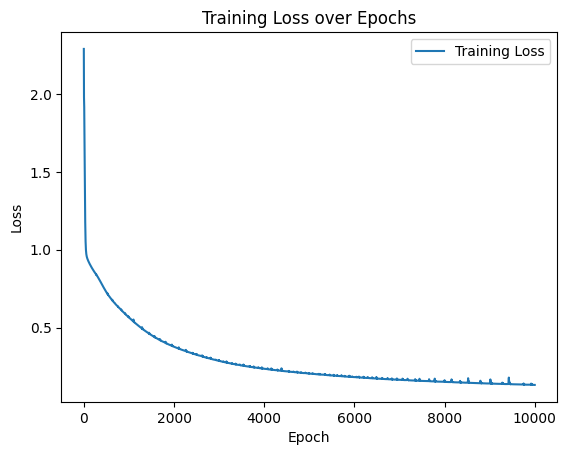

In [17]:
# plot the loss over epochs
%matplotlib inline
plt.plot(range(num_epochs), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

### How can you tell how accurate your model is?

We can see from the above loss that the loss is decreasing showing that as epochs increase, the model is getting better at reproducing the training data overall. To test accuracy, I will see which indices have the highest probabilities and compare them with the actual optimal moves.

In [18]:
model.eval()

correct = 0
outputs = model(train_x)
for output, y_vector in zip(outputs, train_y):
    actual = torch.argmax(y_vector).item()
    pred = torch.argmax(output).item()

    if pred == actual:
        correct += 1

print(f'Accuracy on training data: {correct/outputs.size(0) * 100}')


Accuracy on training data: 95.85399449035813


### How can you avoid overfitting? Do you need to? Why or why not?

In order to avoid overfitting, we should have a test set that acts as real world inputs so we can continually test loss on that set and end the training when that loss starts to increase. When test loss starts to increase as training loss is decreasing, it means that the model is no longer learning about the data and is instead learning about the training set. In this case, we do not need to avoid overfitting because the real world data is the training data that we have. This is due to the fact that the ship is not changing and we have all the information possible, so there is no real need to avoid overfitting. No generalization needed = no overfitting possible.

### Does accuracy of your model translate to effectiveness of a bot based on your model (i.e., can it herd the crew member to the teleport)? Experiment, compare, and verify. Explain your results.

In [19]:
env = Ship_Environment(size=11, has_alien=False)
env.import_ship('our_ship.npy')

# debugging / visualization purposes
# states = []

num_moves = []

for _ in tqdm(range(100)):
    done = False
    for moves in itertools.count():
        # if finish, return number of moves
        if done:
            num_moves.append(moves)
            env.import_ship('our_ship.npy')
            break
        
        # get the bot action from the network
        x = torch.tensor([env.bot, env.crew]).float().to(device)
        bot_action = model.act(x)

        # move the bot
        state, done, reward = env.step(bot_action)

        # debugging / visualization purposes
        # states.append(state/5)

print('---No randomization of bot/crew---')
print(f'Average Number of Moves on until Success: {sum(num_moves)/len(num_moves)}')

num_moves = []

for _ in tqdm(range(100)):
    done = False
    for moves in itertools.count():
        # if finish, return number of moves
        if done:
            num_moves.append(moves)
            env.import_ship('our_ship.npy')
            env.randomize_characters()
            break
        
        # get the bot action from the network
        x = torch.tensor([env.bot, env.crew]).float().to(device)
        bot_action = model.act(x)

        # move the bot
        state, done, reward = env.step(bot_action)

print('---With randomization of bot/crew---')
print(f'Average Number of Moves on until Success: {sum(num_moves)/len(num_moves)}')

C:\Users\aaron\AppData\Local\Temp\ipykernel_22884\1012005063.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crew_idx_0, crew_idx_1 = int(crew_idx[0]), int(crew_idx[1])
C:\Users\aaron\AppData\Local\Temp\ipykernel_22884\1012005063.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bot_idx_0, bot_idx_1 = int(bot_idx[0]), int(bot_idx[1])
100%|██████████| 100/100 [00:02<00:00, 43.51it/s]


---No randomization of bot/crew---
Average Number of Moves on until Success: 31.2


100%|██████████| 100/100 [00:02<00:00, 44.32it/s]

---With randomization of bot/crew---
Average Number of Moves on until Success: 30.05


Does accuracy of your model translate to effectiveness of a bot based on your model (i.e., can it herd the crew member to the teleport)? Experiment, compare, and verify. Explain your results.

The accuracy of my model translates to an effective bot. In every single run, the bot is able to herd the crew into the teleport. When the ship layout is the same as the training, the average number of moves until success is around 30.

### If your initial model fails to translate to an effective bot - try again, and build a model that can be used to guide the bot in place of the computed policy from the previous section. Is your model smaller or larger in memory than the lookup table you computed in the previous section?

Our initial model was able to translate to an effective bot.

# 4 Generalizing

## Try to build and train a model capable of guiding the bot regardless of what ship configuration it is on. How are you approaching this problem? Where are you getting your data from? How can you assess the quality and effectiveness of your model?

First, let's test our model on random configurations.

In [20]:
env = Ship_Environment(size=11, has_alien=False)

# debugging / visualization purposes
# states = []

num_moves = []
failures = 0
for _ in tqdm(range(100)):
    done = False
    for moves in itertools.count():
        if moves > 1000:
            failures += 1
            break
        # if finish, return number of moves
        if done:
            num_moves.append(moves)
            env.reset()
            break
        
        # get the bot action from the network
        x = torch.tensor([env.bot, env.crew]).float().to(device)
        bot_action = model.act(x)

        # move the bot
        state, done, reward = env.step(bot_action)

        # debugging / visualization purposes
        # states.append(state/5)

print('---No randomization of bot/crew---')
print(f'Average Number of Moves on until Success: {sum(num_moves)/len(num_moves)}')
print(f'Failures: {failures}')

100%|██████████| 100/100 [01:00<00:00,  1.64it/s]

---No randomization of bot/crew---
Average Number of Moves on until Success: 80.78571428571429
Failures: 86


### How are you approaching this problem?

In order to solve this problem, we decided to utilize supervised learning to see if we can make a more generalized bot. The input data will be in the form of 12 tuples, 10 for the blocked cells that are randomly initialized, and 2 for the moving players/characters.

In [21]:
class LessSimpleNN(nn.Module):
    def __init__(self):
        super(LessSimpleNN, self).__init__()
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 9)

        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='sigmoid')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='sigmoid')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='sigmoid')

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
    def act(self, x):
        output = self(x.unsqueeze(0))
        softmax_output = F.softmax(output[0], dim=0)
        # probabilities = softmax_output.tolist()
        # action = random.choices(range(len(probabilities)), weights=probabilities, k=1)[0]
        action = torch.argmax(softmax_output, dim=0)
        return action + 1

### Where are you getting your data from? 

To get the data for the supervised learning, I will be repeating problem 2 but for many different ships in order to populate the training data. For testing data, I will be repeating problem 2 as well but for unseen ships. We need testing data now because there is risk of overfitting. I also realized that calculating the true expected value for the optimal bot takes much longer than calculating simple relativity with the expected values but gives very similar results in terms of optimal actions. Due to this, I will instead be calculating this instead to populate data for training.

In [22]:
def get_cardinals(size, point, ev, bot_cell):
        cardinals = []
        for direction in [(0,1), (0,-1), (1,0), (-1,0)]:
            x, y = point[0] + direction[0], point[1] + direction[1]
            if 0 <= x < size and 0 <= y < size and ev[x,y] != -1 and (x,y) != bot_cell:
                cardinals.append((x,y))
        return cardinals

# Directions
    # 
    # 1  2  3
    # 4  5  6
    # 7  8  9
    # 
def get_valid_actions(bot_cell, crew_cell, env):
    directions = {
        1: (bot_cell[0] - 1, bot_cell[1] - 1),  # Top-left
        2: (bot_cell[0] - 1, bot_cell[1]),      # Top
        3: (bot_cell[0] - 1, bot_cell[1] + 1),  # Top-right
        4: (bot_cell[0], bot_cell[1] - 1),      # Left
        5: bot_cell,                            # Center (stay)
        6: (bot_cell[0], bot_cell[1] + 1),      # Right
        7: (bot_cell[0] + 1, bot_cell[1] - 1),  # Bottom-left
        8: (bot_cell[0] + 1, bot_cell[1]),      # Bottom
        9: (bot_cell[0] + 1, bot_cell[1] + 1)   # Bottom-right
    }
    invalid_actions = []
    for direction, temp in directions.items():
        if not (0 <= temp[0] < env.size and 0 <= temp[1] < env.size and env.ship[temp] != 1 and temp != crew_cell):
            invalid_actions.append(direction)
    
    for ia in invalid_actions:
        del directions[ia]

    return directions

optimal_action_dataset = []

# get every combination of coordinates
coordinates = [(i, j) for i in range(env.size) for j in range(env.size)]

for _ in range(50):
    env = Ship_Environment(size=11, has_alien=False)
    ship = env.ship
    indices = np.where(ship == 1)
    wall_coordinates = list(zip(indices[0], indices[1]))

    # key: (bot_cell, crew_cell) 
    # value: expected time
    tbot = {}

    for bot_cell in coordinates:
        for crew_cell in coordinates:
            if crew_cell == (5,5):
                tbot[(bot_cell, crew_cell)] = 0
                continue

            # cannot coexist
            if bot_cell == crew_cell:
                continue

            # cannot be in a wall
            if ship[bot_cell] == -1 or ship[crew_cell] == -1:
                continue

            # average of accessible crew cells
            temp_sum = 0
            accessible_cells = get_cardinals(env.size, crew_cell, expected_values, bot_cell)
            if accessible_cells:
                for ac in accessible_cells:
                    temp_sum += expected_values[ac]
                temp_sum /= len(accessible_cells)
            else:
                temp_sum = np.inf

            # manhattan distance + average of accessible crew cells
            tbot[(bot_cell, crew_cell)] = manhattan_distance(bot_cell, crew_cell) + temp_sum

    for pair, curr_ev in tbot.items():
        bot_cell, crew_cell = pair
        directions = get_valid_actions(bot_cell, crew_cell, env)
        
        # default is stay still, 5
        min_ev = curr_ev
        min_act = 5
        for direction, new_bot_cell in directions.items():
            test_ev = tbot[(new_bot_cell, crew_cell)]
            if test_ev < min_ev:
                min_ev = test_ev
                min_act = direction

        temp = wall_coordinates.copy()
        temp.append(bot_cell)
        temp.append(crew_cell)
        optimal_action_dataset.append((temp, min_act))

print(len(optimal_action_dataset))

726050


In [23]:
# shuffle the dataset
random.shuffle(optimal_action_dataset)

x_values = np.array([item[0] for item in optimal_action_dataset])
y_values = np.array([item[1] for item in optimal_action_dataset])
num_samples = len(x_values)
num_features = x_values.shape[1] * x_values.shape[2]
train_x = x_values.reshape(num_samples, num_features)

# 80/20 split
split_index = int(0.8 * num_samples)

# training and testing sets
train_x, test_x = train_x[:split_index], train_x[split_index:]
train_y, test_y = y_values[:split_index], y_values[split_index:]

train_y = one_hot_encode(train_y)
test_y = one_hot_encode(test_y)

print("Shapes:")
print("train_x:", train_x.shape)
print("train_y:", train_y.shape)
print("test_x:", test_x.shape)
print("test_y:", test_y.shape)

Shapes:
train_x: (580840, 32)
train_y: (580840, 9)
test_x: (145210, 32)
test_y: (145210, 9)


In [24]:
model = LessSimpleNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_x_tensor = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y_tensor = torch.tensor(train_y.argmax(axis=1), dtype=torch.long).to(device)

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

num_epochs = 10
prev_loss = np.inf
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if running_loss/len(train_loader) >= prev_loss:
        break
    prev_loss = running_loss/len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 1.378232826386427
Epoch 2, Loss: 1.3719532596035222
Epoch 3, Loss: 1.371950984198178
Epoch 4, Loss: 1.3719509840405633


In [25]:
# Evaluate on test data
test_x_tensor = torch.tensor(test_x, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y.argmax(axis=1), dtype=torch.long).to(device)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=4)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 2269/2269 [00:06<00:00, 378.16it/s]

Test Accuracy: 17.84%


### How can you assess the quality and effectiveness of your model?

In [26]:
env = Ship_Environment(size=11, has_alien=False)
ship = env.ship
indices = np.where(ship == 1)
wall_coordinates = list(zip(indices[0], indices[1]))
# debugging / visualization purposes
# states = []

num_moves = []
failures = 0
for _ in tqdm(range(100)):
    done = False
    for moves in itertools.count():
        if moves > 1000:
            failures += 1
            break
        # if finish, return number of moves
        if done:
            num_moves.append(moves)
            env.reset()
            break
        
        # get the bot action from the network
        temp = wall_coordinates.copy()
        temp.append(env.bot)
        temp.append(env.crew)
        x = torch.tensor([temp]).float().to(device)
        bot_action = model.act(x)

        # move the bot
        state, done, reward = env.step(bot_action)

        # debugging / visualization purposes
        # states.append(state/5)

print('---No randomization of bot/crew---')
print(f'Average Number of Moves on until Success: {sum(num_moves)/len(num_moves)}')
print(f'Failures: {failures}')

100%|██████████| 100/100 [00:13<00:00,  7.47it/s]

---No randomization of bot/crew---
Average Number of Moves on until Success: 246.46938775510205
Failures: 2


In [43]:
# debugging / visualization purposes
# grid_size = 11
# fig, ax = plt.subplots(figsize=(11,8))

# # heatmap
# heatmap = ax.imshow(np.zeros_like(states[0]), cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
# plt.colorbar(heatmap, ax=ax)
# ax.set_xlim(0, grid_size)
# ax.set_ylim(0, grid_size)
# ax.set_aspect('equal')
# ax.set_title('Ship Environment')

# ax.invert_yaxis()

# def update(frame):
#     # update
#     heatmap.set_array(states[frame])

# ani = FuncAnimation(fig, update, frames=len(states), repeat=False)

# %matplotlib notebook
# display(HTML(ani.to_jshtml()))

### Bonus Question

In this section, since we have alien too, we are creating a 6d matrix instead with additional alien parameters. Our approach to calculating the Expected Time involves initially considering every possible bot position. For each bot position, we verify its validity. If it's valid, we explore all potential configurations of alien cells, ensuring they are within bounds and not obstructed. Additionally, we impose conditions to ensure that prospective alien positions do not overlap with bot positions. Once we've filtered out all bot-alien pairs for a given bot position, we proceed to evaluate all possible crew positions. Here, we ensure that crew future positions do not intersect with either bot or alien positions.	
Thus we can find the expected time for any bot-alien-crew cell combination by looking at the value of the 6D array at the given bot, alien  and crew cell.


In [10]:
env = Ship_Environment(size=11, has_alien=False)
env.import_ship('our_ship.npy')
ship = env.ship

/var/folders/vy/n381153x4ml802r36d69217w0000gn/T/ipykernel_4833/223742385.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  crew_idx_0, crew_idx_1 = int(crew_idx[0]), int(crew_idx[1])
/var/folders/vy/n381153x4ml802r36d69217w0000gn/T/ipykernel_4833/223742385.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bot_idx_0, bot_idx_1 = int(bot_idx[0]), int(bot_idx[1])


In [11]:
def get_cardinals_avoid_bot_alien(size, crew_point, ship, bot_point, alien_point):
    cardinals = []
    for direction in [(0,-1), (0, 1), (1, 0), (-1, 0)]:
        alien_x, alien_y = direction[0] + alien_point[0], direction[1] + alien_point[1]
        if (alien_x, alien_y) != bot_point and (0 <= alien_x < size and 0 <= alien_y < size) and ship[alien_x][alien_y] != 1 :
            # checking bot's movement
            for direction in [(0,1), (0,-1), (1,0), (-1,0)]:
                x, y = crew_point[0] + direction[0], crew_point[1] + direction[1]
                if 0 <= x < size and 0 <= y < size and ship[x][y] != 1 and (x,y) != bot_point and (x,y) != alien_point:
                    cardinals.append((x,y))
    return cardinals

def get_possible_bot_moves_with_alien(size, crew_point, ship, bot_point, alien_point):
    moves = []
    for direction in [(0,1), (0,-1), (1,0), (-1,0), (0,0), (1,1), (1,-1), (-1,1), (-1,-1)]:
        x, y = bot_point[0] + direction[0], bot_point[1] + direction[1]
        if 0 <= x < size and 0 <= y < size and ship[x][y] != 1 and (x,y) != crew_point and (x,y) != alien_point:
            moves.append((x,y))
    return moves

expected_values_6d = np.zeros([11, 11, 11, 11, 11, 11])
temp = np.zeros([11, 11, 11, 11, 11, 11])
convergence = False

while not convergence:
    for bot_x in range(expected_values_6d.shape[0]):
        for bot_y in range(expected_values_6d.shape[0]):
            # If the bot is not in a blocked cell
            if ship[bot_x,bot_y] == 1:
                for alien_x in range(expected_values_6d.shape[0]):
                    for alien_y in range(expected_values_6d.shape[0]):
                        for crew_x in range(expected_values_6d.shape[2]):
                            for crew_y in range(expected_values_6d.shape[3]):
                                expected_values_6d[bot_x,bot_y,alien_x,alien_y,crew_x,crew_y] = -1
                                temp[bot_x,bot_y,alien_x,alien_y,crew_x,crew_y] = -1
                continue
            
            for alien_x in range(expected_values_6d.shape[0]):
                for alien_y in range(expected_values_6d.shape[0]):
                # if alien in blocked cell
                    if ship[alien_x,alien_y] == 1:
                        for crew_x in range(expected_values_6d.shape[0]):
                            for crew_y in range(expected_values_6d.shape[0]):
                                expected_values_6d[bot_x,bot_y,alien_x,alien_y,crew_x,crew_y] = -1
                                temp[bot_x,bot_y,alien_x,alien_y,crew_x,crew_y] = -1
                        continue
                    
                    # Tbot(tp pad) = 0 regardless of where the bot is
                    expected_values_6d[bot_x,bot_y,alien_x,alien_y,0,0] = 0
                    for crew_x in range(expected_values_6d.shape[0]):
                        for crew_y in range(expected_values_6d.shape[0]):
                            if (crew_x,crew_y) == (5,5):
                                continue
                            if ship[crew_x,crew_y] == 1:
                                expected_values_6d[bot_x,bot_y,alien_x,alien_y,crew_x,crew_y] = -1
                                temp[bot_x,bot_y,alien_x,alien_y,crew_x,crew_y] = -1
                                continue
                            possible_moves = get_possible_bot_moves_with_alien(expected_values_6d.shape[0], (crew_x,crew_y), ship, (bot_x,bot_y), (alien_x,alien_y))
                            if len(possible_moves) <= 0:
                                expected_values_6d[bot_x,bot_y,alien_x,alien_y,crew_x,crew_y] = -1
                                temp[bot_x,bot_y,alien_x,alien_y,crew_x,crew_y] = -1
                                continue
                            current_min_avg = 1000
                            for possible_move in possible_moves:
                                possible_move_x, possible_move_y = possible_move
                                neighbors = get_cardinals_avoid_bot_alien(expected_values_6d.shape[0], (crew_x,crew_y), ship, (possible_move_x,possible_move_y), (alien_x, alien_y))
                                if len(neighbors) <= 0:
                                    expected_values_6d[bot_x,bot_y,alien_x,alien_y,crew_x,crew_y] = -1
                                    temp[bot_x,bot_y,alien_x,alien_y,crew_x,crew_y] = -1
                                    continue
                                temp_sum = 0
                                for neighbor in neighbors:
                                    neighbor_x, neighbor_y = neighbor
                                    temp_sum += expected_values_6d[possible_move_x, possible_move_y, alien_x, alien_y, neighbor_x, neighbor_y]
                                if temp_sum != 0: current_min_avg = min(current_min_avg, 1 / len(neighbors) * temp_sum)
                                
                            temp[bot_x,bot_y,crew_x,crew_y] = 1 + current_min_avg
    if np.all(np.abs(expected_values_6d-temp) <= .001):
        convergence = True
    expected_values_6d = temp.copy()
    

# np.savetxt('test.txt', expected_values, fmt='%.2f')
print("Finished! Total iterations:")
print(expected_values_6d)


In [ ]:
# Directions
    # 
    # 1  2  3
    # 4  5  6
    # 7  8  9
    # 
def get_valid_actions_bot(bot_cell, crew_cell, alien_cell, env):
    directions = {
        1: (bot_cell[0] - 1, bot_cell[1] - 1),  # Top-left
        2: (bot_cell[0] - 1, bot_cell[1]),      # Top
        3: (bot_cell[0] - 1, bot_cell[1] + 1),  # Top-right
        4: (bot_cell[0], bot_cell[1] - 1),      # Left
        5: bot_cell,                            # Center (stay)
        6: (bot_cell[0], bot_cell[1] + 1),      # Right
        7: (bot_cell[0] + 1, bot_cell[1] - 1),  # Bottom-left
        8: (bot_cell[0] + 1, bot_cell[1]),      # Bottom
        9: (bot_cell[0] + 1, bot_cell[1] + 1)   # Bottom-right
    }
    invalid_actions = []
    for direction, temp in directions.items():
        if not (0 <= temp[0] < env.size and 0 <= temp[1] < env.size and env.ship[temp] != 1 and temp != crew_cell and temp != alien_cell):
            invalid_actions.append(direction)
    
    for ia in invalid_actions:
        del directions[ia]

    return directions

def get_expected_value_alien_crew(env, ev, bot_cell, crew_cell, alien_cell):
    evs = []

# checking alien's movement 
    for direction in [(0,-1), (0, 1), (1, 0), (-1, 0)]:
        alien_x, alien_y = direction[0] + alien_cell[0], direction[1] + alien_cell[1]
        if (alien_x, alien_y) != bot_cell and (0 <= alien_x < env.size and 0 <= alien_y < env.size) and ev[bot_cell][(alien_x, alien_y)] >= 0:
            # checking bot's movement
            for direction in [(0,-1), (0, 1), (1, 0), (-1, 0)]:
                crew_x, crew_y = direction[0] + crew_cell[0], direction[1] + crew_cell[1]
                if (crew_x, crew_y) != bot_cell and (0 <= crew_x < env.size and 0 <= crew_y < env.size) and ev[bot_cell][(crew_x, crew_y)] >= 0:
                    evs.append(ev[bot_cell][(alien_x, alien_y)][(crew_x, crew_y)])
    
    if len(evs) <= 0:
        return np.inf
    
    return np.mean(evs)

optimal_action = {}

coordinates = [(x,y) for x in range(env.size) for y in range(env.size)]
for bot_cell in coordinates:
    for alien_cell in coordinates:
        if bot_cell == alien_cell:
            continue
        for crew_cell in coordinates:
            if bot_cell == crew_cell or crew_cell == alien_cell:
                continue
            
            if crew_cell == (5,5):
                continue

            directions = get_valid_actions_bot(bot_cell, crew_cell, alien_cell, env)

            # default is stay still, 5
            min_ev = get_expected_value_alien_crew(env, expected_values_6d, bot_cell, crew_cell, alien_cell)
            min_act = 5

            for direction, new_bot_cell in directions.items():
                test_ev = get_expected_value_alien_crew(env, expected_values_6d, bot_cell, crew_cell, alien_cell)

                if test_ev < min_ev:
                    min_ev = test_ev
                    min_act = direction
            optimal_action[bot_cell, alien_cell, crew_cell] = min_act

In [ ]:
class SimpleNN_Bonus(nn.Module):
    def __init__(self):
        super(SimpleNN_Bonus, self).__init__()
        self.fc1 = nn.Linear(6, 64)  # Bot_pos, Alien_pos, Crew_pos
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 9)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def act(self, x):
        output = self(x.unsqueeze(0))
        softmax_output = F.softmax(output[0], dim=0)
        # probabilities = softmax_output.tolist()
        # action = random.choices(range(len(probabilities)), weights=probabilities, k=1)[0]
        action = torch.argmax(softmax_output, dim=0)
        return action + 1

In [ ]:
def one_hot_encode_bonus(digits):
    digit_to_index = {digit: idx for idx, digit in enumerate(range(1, 10))}
    
    num_classes = len(digit_to_index)
    
    encoded_vectors = np.zeros((len(digits), num_classes), dtype=int)
    
    for i, digit in enumerate(digits):
        index = digit_to_index[digit]
        encoded_vectors[i, index] = 1
    
    return encoded_vectors

train_x = torch.tensor(list(optimal_action.keys())).float().to(device)
train_y = torch.tensor(one_hot_encode_bonus(list(optimal_action.values()))).float().to(device)

In [ ]:
losses = []

model = SimpleNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model.train()
num_epochs = 10000
for epoch in range(num_epochs):

    output = model(train_x)

    loss = criterion(output, train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')

In [ ]:
# plot the loss over epochs
%matplotlib inline
plt.plot(range(num_epochs), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
model.eval()

correct = 0
outputs = model(train_x)
for output, y_vector in zip(outputs, train_y):
    actual = torch.argmax(y_vector).item()
    pred = torch.argmax(output).item()

    if pred == actual:
        correct += 1

print(f'Accuracy on training data: {correct/outputs.size(0) * 100}')

In [ ]:
env = Ship_Environment(size=11, has_alien=True)

# debugging / visualization purposes
# states = []

num_moves = []
failures = 0
for _ in tqdm(range(100)):
    done = False
    for moves in itertools.count():
        if moves > 1000:
            failures += 1
            break
        # if finish, return number of moves
        if done:
            num_moves.append(moves)
            env.reset()
            break
        
        # get the bot action from the network
        x = torch.tensor([env.bot, env.crew]).float().to(device)
        bot_action = model.act(x)

        # move the bot
        state, done, reward = env.step(bot_action)

        # debugging / visualization purposes
        # states.append(state/5)

print('---No randomization of bot/crew---')
print(f'Average Number of Moves on until Success: {sum(num_moves)/len(num_moves)}')
print(f'Failures: {failures}')

In [ ]:
class LessSimpleNN(nn.Module):
    def __init__(self):
        super(LessSimpleNN, self).__init__()
        self.fc1 = nn.Linear(34, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 9)

        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='sigmoid')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='sigmoid')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='sigmoid')

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
    def act(self, x):
        output = self(x.unsqueeze(0))
        softmax_output = F.softmax(output[0], dim=0)
        # probabilities = softmax_output.tolist()
        # action = random.choices(range(len(probabilities)), weights=probabilities, k=1)[0]
        action = torch.argmax(softmax_output, dim=0)
        return action + 1

In [ ]:
def get_cardinals(size, crew_point, ev , bot_point, alien_point):
    cardinals = []
    for direction in [(0,-1), (0, 1), (1, 0), (-1, 0)]:
        alien_x, alien_y = direction[0] + alien_point[0], direction[1] + alien_point[1]
        if (alien_x, alien_y) != bot_point and (0 <= alien_x < size and 0 <= alien_y < size) and ship[alien_x][alien_y] != 1 :
            # checking bot's movement
            for direction in [(0,1), (0,-1), (1,0), (-1,0)]:
                x, y = crew_point[0] + direction[0], crew_point[1] + direction[1]
                if 0 <= x < size and 0 <= y < size and ship[x][y] != 1 and (x,y) != bot_point and (x,y) != alien_point:
                    cardinals.append((x,y))
    return cardinals

# Directions
    # 
    # 1  2  3
    # 4  5  6
    # 7  8  9
    # 
def get_valid_actions(bot_cell, crew_cell, alien_cell, env):
    directions = {
        1: (bot_cell[0] - 1, bot_cell[1] - 1),  # Top-left
        2: (bot_cell[0] - 1, bot_cell[1]),      # Top
        3: (bot_cell[0] - 1, bot_cell[1] + 1),  # Top-right
        4: (bot_cell[0], bot_cell[1] - 1),      # Left
        5: bot_cell,                            # Center (stay)
        6: (bot_cell[0], bot_cell[1] + 1),      # Right
        7: (bot_cell[0] + 1, bot_cell[1] - 1),  # Bottom-left
        8: (bot_cell[0] + 1, bot_cell[1]),      # Bottom
        9: (bot_cell[0] + 1, bot_cell[1] + 1)   # Bottom-right
    }
    invalid_actions = []
    for direction, temp in directions.items():
        if not (0 <= temp[0] < env.size and 0 <= temp[1] < env.size and env.ship[temp] != 1 and temp != crew_cell and temp != alien_cell):
            invalid_actions.append(direction)
    
    for ia in invalid_actions:
        del directions[ia]

    return directions

optimal_action_dataset = []

# get every combination of coordinates
coordinates = [(i, j) for i in range(env.size) for j in range(env.size)]

for _ in range(50):
    env = Ship_Environment(size=11, has_alien=False)
    ship = env.ship
    indices = np.where(ship == 1)
    wall_coordinates = list(zip(indices[0], indices[1]))

    # key: (bot_cell, crew_cell) 
    # value: expected time
    tbot = {}

    for bot_cell in coordinates:
        for alien_cell in coordinates:
            if bot_cell == alien_cell:
                continue
            for crew_cell in coordinates:
                if bot_cell == crew_cell or crew_cell == alien_cell:
                    continue
                
                if crew_cell == (5,5):
                    tbot[(bot_cell, crew_cell)] = 0
                    continue

                # cannot be in a wall
                if ship[bot_cell] == -1 or ship[crew_cell] == -1 or ship[alien_cell] == -1:
                    continue

                # average of accessible crew cells
                temp_sum = 0
                accessible_cells = get_cardinals(env.size, crew_cell, expected_values, bot_cell, alien_cell)
                if accessible_cells:
                    for ac in accessible_cells:
                        temp_sum += expected_values[ac]
                    temp_sum /= len(accessible_cells)
                else:
                    temp_sum = np.inf

                # manhattan distance + average of accessible crew cells
                tbot[(bot_cell, alien_cell, crew_cell)] = manhattan_distance(bot_cell, crew_cell) + temp_sum

    for pair, curr_ev in tbot.items():
        bot_cell, crew_cell = pair
        directions = get_valid_actions(bot_cell, crew_cell, alien_cell, env)
        
        # default is stay still, 5
        min_ev = curr_ev
        min_act = 5
        for direction, new_bot_cell in directions.items():
            test_ev = tbot[(new_bot_cell, alien_cell, crew_cell)]
            if test_ev < min_ev:
                min_ev = test_ev
                min_act = direction

        temp = wall_coordinates.copy()
        temp.append(bot_cell)
        temp.append(alien_cell)
        temp.append(crew_cell)
        optimal_action_dataset.append((temp, min_act))

print(len(optimal_action_dataset))

In [ ]:
# shuffle the dataset
random.shuffle(optimal_action_dataset)

x_values = np.array([item[0] for item in optimal_action_dataset])
y_values = np.array([item[1] for item in optimal_action_dataset])
num_samples = len(x_values)
num_features = x_values.shape[1] * x_values.shape[2]
train_x = x_values.reshape(num_samples, num_features)

# 80/20 split
split_index = int(0.8 * num_samples)

# training and testing sets
train_x, test_x = train_x[:split_index], train_x[split_index:]
train_y, test_y = y_values[:split_index], y_values[split_index:]

train_y = one_hot_encode(train_y)
test_y = one_hot_encode(test_y)

print("Shapes:")
print("train_x:", train_x.shape)
print("train_y:", train_y.shape)
print("test_x:", test_x.shape)
print("test_y:", test_y.shape)

In [ ]:
model = LessSimpleNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_x_tensor = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y_tensor = torch.tensor(train_y.argmax(axis=1), dtype=torch.long).to(device)

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

num_epochs = 10
prev_loss = np.inf
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if running_loss/len(train_loader) >= prev_loss:
        break
    prev_loss = running_loss/len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

In [ ]:
# Evaluate on test data
test_x_tensor = torch.tensor(test_x, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y.argmax(axis=1), dtype=torch.long).to(device)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=4)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")